In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler

In [257]:
def convert_sales_unit(str):
    try:
        result = float(str)
        return result
    except ValueError:
        result = str
        if 'M' in str:
            result = str.replace('M', '')
        elif 'K' in str:
            result = str.replace('K', '')
            result = float(result) * 0.001
        return result

def convert_digit_year(year):
    if "N/A" != year:
        result = str(year)
        result = result.split('.')[0]
        if len(result) == 2:
            if result[0] == '9':
                result = '19' + result
            elif result[0] == '8':
                result = '19' + result
            elif result[0] == '1':
                result = '20' + result
        elif len(result) == 1:
            result = '200' + result
        return result

def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

def year_genre(df, sales_str):
    year_group = df.groupby(["Year", "Genre"])[sales_str].sum()
    year_group_max = year_group.max(level = "Year")
    df_year_group_max = year_group_max.reset_index()
    df_year_group = year_group.reset_index()
    df_result = pd.merge(left = df_year_group, right = df_year_group_max,  how = "inner")
    return df_result

In [258]:
csv = pd.read_csv('./vgames2.csv')
# csv = csv.set_index(csv.columns[0])

- 데이터를 보니 휴대용, 콘솔게임으로 이루어진 풀 프라이스 패키지게임 모음.
- 단위 확인을 위한 임의 데이터로 검색 (SimEarth: The Living Planet)
- 단위는 m 이고 160K = 0.16m

In [259]:
df = csv.copy()

#지역별 누적판매량 단위 맞춤 ( K, M )
df["NA_Sales"]    = pd.to_numeric(csv["NA_Sales"].apply(convert_sales_unit))
df["EU_Sales"]    = pd.to_numeric(csv["EU_Sales"].apply(convert_sales_unit))
df["JP_Sales"]    = pd.to_numeric(csv["JP_Sales"].apply(convert_sales_unit))
df["Other_Sales"] = pd.to_numeric(csv["Other_Sales"].apply(convert_sales_unit))

#년도 네자리로 맞춤
df["Year"] = csv["Year"].apply(convert_digit_year)

#년도 결측값 _게임타이틀중 3개의 평균값
year_means = {
    "2600": 1980
    ,"GB" : 1998
    ,"N64": 1998
    ,"PS" : 2001
    ,"GBA": 2003
    ,"XB" : 2003
    ,"GC" : 2004
    ,"PS2": 2005
    ,"DS" : 2007
    ,"PSP": 2009
    ,"Wii": 2010
    ,"3DS": 2011
    ,"PC" : 2011
    ,"PSV": 2013
    ,"X360": 2011
    ,"PS3": 2012
}
years = df["Year"].copy()
for v, (platform, year) in enumerate(zip(df["Platform"], years)):
    if "nan" == year:
        years[v] = year_means[platform]

df["Year"] = pd.to_numeric(years)

#이후 결측치 제거(장르 구분 안되있는것들)
df = df.dropna(axis=0)

In [260]:
#총 누적판매량 피쳐 생성
df["Total_Sales"] = df["NA_Sales"] + df["EU_Sales"] + df["JP_Sales"] + df["Other_Sales"]

#년도별 가장 많이 팔린 장르
for_year = df.groupby(["Year", "Genre"])['Total_Sales'].sum()
for_year_max = for_year.max(level = "Year")
df_for_year_max = for_year_max.reset_index()
df_for_year = for_year.reset_index()
df_year = pd.merge(left = df_for_year, right = df_for_year_max,  how = "inner")
df_year

C:\Users\Gak\AppData\Local\Temp/ipykernel_11472/2624617666.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  for_year_max = for_year.max(level = "Year")


,Year,Genre,Total_Sales
0,1980,Shooter,10.58
1,1981,Action,14.79
2,1982,Puzzle,10.04
3,1983,Platform,6.93
4,1984,Shooter,31.10
5,1985,Platform,43.17
6,1986,Action,13.74
7,1987,Fighting,5.42
8,1988,Platform,27.73
9,1989,Puzzle,37.75


In [261]:
#2017년 부터 데이터 확인
df[df["Year"] >= 2017]

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
5310,5311,Brothers Conflict: Precious Baby,PSV,2017,Action,Idea Factory,0.00,0.0,0.01,0.00,0.01
6906,6907,Imagine: Makeup Artist,DS,2020,Simulation,Ubisoft,0.27,0.0,0.00,0.02,0.29
10107,10108,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017,Role-Playing,Sega,0.00,0.0,0.03,0.00,0.03
15233,15234,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017,Role-Playing,Sega,0.00,0.0,0.01,0.00,0.01


Imagine: Makeup Artist는 2009년 4월 16일 발매된 게임으로 제거 처리

In [262]:
df = df.drop(6906)
df_for_year_max = df_for_year_max.drop(38)
df_for_year = df_for_year.drop(391)

#2017년 이후 게임발매 (2018~)

## 년도별 인기있는 장르를 알아보자.

In [263]:
genre = df_for_year["Genre"]
misc        = df_for_year[genre == "Misc"]
action      = df_for_year[genre == "Action"]
strategy    = df_for_year[genre == "Strategy"]
platform    = df_for_year[genre == "Platform"]
shooter     = df_for_year[genre == "Shooter"]
racing      = df_for_year[genre == "Racing"]
sports      = df_for_year[genre == "Sports"]
simulation  = df_for_year[genre == "Simulation"]
puzzle      = df_for_year[genre == "Puzzle"]
fighting    = df_for_year[genre == "Fighting"]
adventure   = df_for_year[genre == "Adventure"]
role_playing = df_for_year[genre == "Role-Playing"]


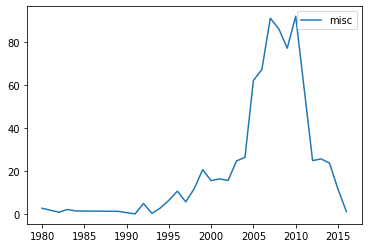

In [264]:
plt.plot(misc["Year"], misc["Total_Sales"])
plt.legend(["misc"])

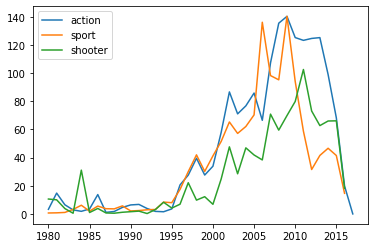

In [265]:
plt.plot(action["Year"], action["Total_Sales"])
plt.plot(sports["Year"], sports["Total_Sales"])
plt.plot(shooter["Year"], shooter["Total_Sales"])
plt.legend(["action", "sport", "shooter"])

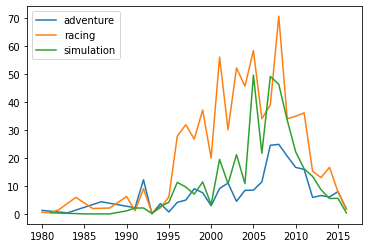

In [266]:
plt.plot(adventure["Year"], adventure["Total_Sales"])
plt.plot(racing["Year"], racing["Total_Sales"])
plt.plot(simulation["Year"], simulation["Total_Sales"])
plt.legend(["adventure", "racing", "simulation"])

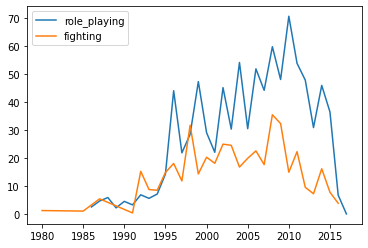

In [267]:
plt.plot(role_playing["Year"], role_playing["Total_Sales"])
plt.plot(fighting["Year"], fighting["Total_Sales"])
plt.legend(["role_playing", "fighting"])

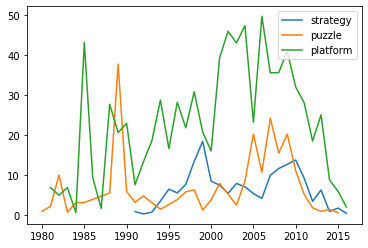

In [268]:
plt.plot(strategy["Year"], strategy["Total_Sales"])
plt.plot(puzzle["Year"], puzzle["Total_Sales"])
plt.plot(platform["Year"], platform["Total_Sales"])
plt.legend(["strategy", "puzzle", "platform"])



## 지역에 따른 선호 게임 차이

In [269]:
#표준화
sales_list = ["NA_Sales", "EU_Sales", "JP_Sales" ,"Other_Sales", "Total_Sales"]
Indicator_list = ["Unnamed: 0","Name", "Platform", "Year", "Genre", "Publisher"]
df_minmax_norm = minmax_norm(df[sales_list])
df_standard2 = pd.concat((df[Indicator_list], df_minmax_norm), axis = 1)

In [270]:
#상관관계 분석
na_eu = np.corrcoef(df_standard2["NA_Sales"], df_standard2["EU_Sales"])[0, 1]
na_jp = np.corrcoef(df_standard2["NA_Sales"], df_standard2["JP_Sales"])[0, 1]
eu_jp = np.corrcoef(df_standard2["EU_Sales"], df_standard2["JP_Sales"])[0, 1]
na_other = np.corrcoef(df_standard2["NA_Sales"], df_standard2["Other_Sales"])[0, 1]
jp_other = np.corrcoef(df_standard2["JP_Sales"], df_standard2["Other_Sales"])[0, 1]
print("na_eu", na_eu)
print("na_jp", na_jp)
print("eu_jp", eu_jp)
print("jp_other", jp_other)

na_eu 0.7676520440931759
na_jp 0.44793254357039014
eu_jp 0.43162445500157876
jp_other 0.2849870180677954


북미 최대 판매 타이틀 Top5

In [271]:
df_standard2.nlargest(5, ["NA_Sales"])[["Name", "Platform", "Genre", "NA_Sales", "Total_Sales"]]

,Name,Platform,Genre,NA_Sales,Total_Sales
2908,Wii Sports,Wii,Sports,1.000000,1.000000
4199,Super Mario Bros.,NES,Platform,0.700892,0.486343
10488,Duck Hunt,NES,Shooter,0.649072,0.342156
1203,Tetris,GB,Puzzle,0.559171,0.365724
12579,Mario Kart Wii,Wii,Racing,0.382020,0.433043


유럽 최대 판매 타이틀 Top5

In [272]:
df_standard2.nlargest(5, ["EU_Sales"])[["Name", "Platform", "Genre", "EU_Sales", "Total_Sales"]]

,Name,Platform,Genre,EU_Sales,Total_Sales
2908,Wii Sports,Wii,Sports,1.000000,1.000000
12579,Mario Kart Wii,Wii,Racing,0.443832,0.433043
3352,Wii Sports Resort,Wii,Sports,0.379394,0.398840
11137,Nintendogs,DS,Simulation,0.379049,0.299130
3483,Grand Theft Auto V,PS3,Action,0.319435,0.258521


일본 최대 판매 타이틀 Top5

In [273]:
df_standard2.nlargest(5, ["JP_Sales"])[["Name", "Platform", "Genre", "JP_Sales", "Total_Sales"]]

,Name,Platform,Genre,JP_Sales,Total_Sales
7829,Pokemon Red/Pokemon Blue,GB,Role-Playing,1.000000,0.379260
9416,Pokemon Gold/Pokemon Silver,GB,Role-Playing,0.704501,0.279067
4199,Super Mario Bros.,NES,Platform,0.666341,0.486343
6937,New Super Mario Bros.,DS,Platform,0.636008,0.362702
10555,Pokemon Diamond/Pokemon Pearl,DS,Role-Playing,0.590998,0.221779


그외 기타 최대 판매 타이틀 Top5

In [274]:
df_standard2.nlargest(5, ["Other_Sales"])[["Name", "Platform", "Genre", "Other_Sales", "Total_Sales"]]

,Name,Platform,Genre,Other_Sales,Total_Sales
14669,Grand Theft Auto: San Andreas,PS2,Action,1.000000,0.251511
2908,Wii Sports,Wii,Sports,0.800378,1.000000
14665,Gran Turismo 4,PS2,Racing,0.712394,0.140803
3483,Grand Theft Auto V,PS3,Action,0.391675,0.258521
12579,Mario Kart Wii,Wii,Racing,0.313150,0.433043


In [275]:
na_genre = year_genre(df, "NA_Sales")
na_genre.groupby("Genre").count()

C:\Users\Gak\AppData\Local\Temp/ipykernel_11472/1283388508.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  year_group_max = year_group.max(level = "Year")


,Year,NA_Sales
Genre,,
Action,14,14
Fighting,1,1
Platform,9,9
Puzzle,2,2
Racing,3,3
Role-Playing,1,1
Shooter,4,4
Sports,5,5


In [276]:
eu_genre = year_genre(df, "EU_Sales")
eu_genre.groupby("Genre").count()

C:\Users\Gak\AppData\Local\Temp/ipykernel_11472/1283388508.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  year_group_max = year_group.max(level = "Year")


,Year,EU_Sales
Genre,,
Action,15,15
Adventure,1,1
Fighting,1,1
Platform,8,8
Puzzle,2,2
Racing,2,2
Role-Playing,3,3
Shooter,4,4
Sports,3,3


In [277]:
jp_genre = year_genre(df, "JP_Sales")
jp_genre.groupby("Genre").count()

C:\Users\Gak\AppData\Local\Temp/ipykernel_11472/1283388508.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  year_group_max = year_group.max(level = "Year")


,Year,JP_Sales
Genre,,
Action,5,5
Adventure,1,1
Fighting,2,2
Misc,2,2
Platform,6,6
Puzzle,4,4
Racing,3,3
Role-Playing,26,26
Shooter,3,3


In [278]:
other_genre = year_genre(df, "Other_Sales")
other_genre.groupby("Genre").count()

C:\Users\Gak\AppData\Local\Temp/ipykernel_11472/1283388508.py:34: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  year_group_max = year_group.max(level = "Year")


,Year,Other_Sales
Genre,,
Action,16,16
Fighting,2,2
Platform,8,8
Puzzle,2,2
Role-Playing,4,4
Shooter,4,4
Sports,4,4


 - 2018 년 이후 게임을 출시해야함, wii는 2013년 단종
 - PC, PS4, X360 기준으로 선정
 - 멀티플랫폼을 노린다.

In [279]:
filter_platform = df_standard2["Platform"].str.contains("PC|PS4|X360")
df_filtered = df_standard2[filter_platform]
df_filtered.nlargest(6, ["Total_Sales"])

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
4343,4344,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,0.360810,0.170227,0.023483,0.157994,0.263718
10913,10914,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,0.232104,0.182977,0.005871,0.130558,0.197970
2809,2810,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,0.217643,0.147484,0.012720,0.124882,0.178390
6248,6249,Call of Duty: Black Ops,X360,2010,Shooter,Activision,0.233068,0.128532,0.010763,0.106906,0.176940
9070,9071,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,0.139070,0.200207,0.034247,0.218543,0.172105
6393,6394,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,0.198843,0.148174,0.006849,0.105960,0.166062


In [280]:
#메타크리틱 점수 불러오기
csv2 = pd.read_csv("./shooter.csv")
csv2

,Unnamed: 0,Metacritic
0,10914,97
1,2810,88
2,6249,87
3,9071,83
4,6394,83
5,6237,94
6,10732,76
7,1627,55
8,7474,53
9,9374,70


In [314]:
#메타크리틱 점수 표준화
df_metacritic = csv2.copy()
df_metacritic["Metacritic"] = minmax_norm(csv2["Metacritic"])

#총 누계판매량과 join
df2 = pd.merge(left = df_metacritic, right = df,  how = "inner", on="Unnamed: 0")
df2

,Unnamed: 0,Metacritic,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,10914,1.000000,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
1,2810,0.795455,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
2,6249,0.772727,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
3,9071,0.681818,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4,6394,0.681818,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
5,6237,0.931818,Call of Duty: Modern Warfare 2,X360,2009,Shooter,Activision,8.52,3.63,0.08,1.29,13.52
6,10732,0.522727,LEGO Star Wars III: The Clone Wars,PC,2011,Action,LucasArts,0.10,0.13,0.00,0.03,0.26
7,1627,0.045455,The Amazing Spider-Man 2 (2014),X360,2014,Action,Activision,0.10,0.14,0.00,0.02,0.26
8,7474,0.000000,Dead or Alive Xtreme 2,X360,2006,Sports,Tecmo Koei,0.15,0.03,0.06,0.02,0.26
9,9374,0.386364,Ninja Gaiden 3,X360,2012,Action,Tecmo Koei,0.16,0.05,0.03,0.02,0.26


In [318]:
df3 = df2[["Year", "Total_Sales", "Metacritic"]]
# plt.plot(df3["Year"], df3["Metacritic"])
df3["Total_Sales"] = minmax_norm(df2["Total_Sales"])
df3 = df3.sort_values(by="Total_Sales")
df3

C:\Users\Gak\AppData\Local\Temp/ipykernel_11472/1320909115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Total_Sales"] = minmax_norm(df2["Total_Sales"])


,Year,Total_Sales,Metacritic
6,2011,0.000000,0.522727
7,2014,0.000000,0.045455
8,2006,0.000000,0.000000
9,2012,0.000000,0.386364
10,2015,0.000000,0.363636
11,2010,0.000000,0.000000
5,2009,0.822581,0.931818
4,2012,0.836228,0.681818
3,2015,0.867246,0.681818
2,2010,0.892060,0.772727


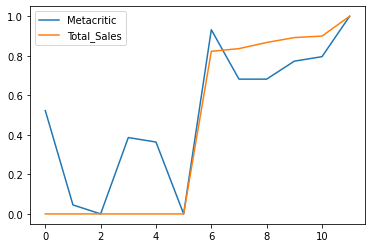

In [317]:
plt.plot(np.arange(0, 12, 1), df3["Metacritic"])
plt.plot(np.arange(0, 12, 1), df3["Total_Sales"])
plt.legend(["Metacritic", "Total_Sales"])

In [322]:
meta_sales = np.corrcoef(df3["Metacritic"], df3["Total_Sales"])[0, 1]
print("메타크리틱 점수와 매출의 상관관계 정도 : ", meta_sales)

메타크리틱 점수와 매출의 상관관계 정도 :  0.8735227436151219
